# Problem Set #2
## Name: Weiwei Zheng

### Problem 1

a) Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title

In [1]:
import numpy as np
import scipy.stats as sts
import pdb
# import data
income = np.loadtxt('incomes.txt')
income.shape

(200,)

<IPython.core.display.Javascript object>


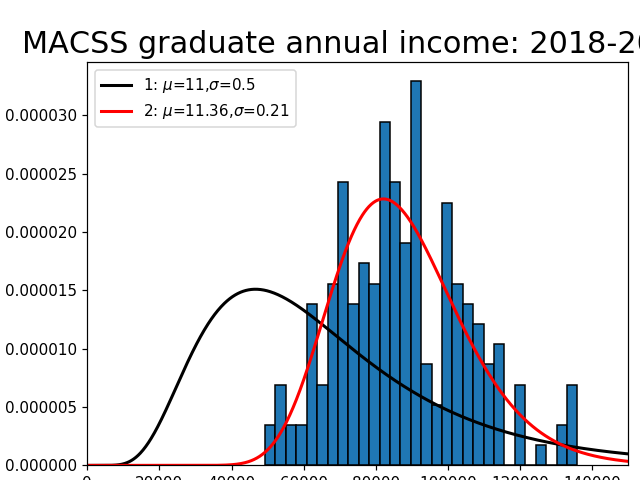

(0, 150000)

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('MACSS graduate annual income: 2018-2020', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Percent of income')
plt.xlim([0, 150000])  

b) Plot the lognormal PDF f(xjµ = 11:0; σ = 0:5) for 0 ≤ x ≤ 150; 000. What is the value of the log likelihood value for this parameterization of the distribution and given this data?

In [3]:
# lognormal pdf
def lognorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and standard
    deviation sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values > 0 of the lognormally distributed random
             variable
    mu     = scalar > 0, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    RETURNS: vector
    --------------------------------------------------------------------
    '''
    
    return (1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma ** 2)))

In [4]:
# plot the graph, see above
mu_1 = 11
sig_1 = 0.5
xvals_1 = np.linspace(0.1, 150000, 1000) ###
pdf_vals_1 = lognorm_pdf(xvals_1, mu_1, sig_1)

plt.plot(xvals_1, pdf_vals_1,
         linewidth=2, color='k', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

In [5]:
#log likelihood
def log_lik_lognorm(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given lognormal
    distribution parameters mu and sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values > 0 of the lognormally distributed random
             variable
    mu     = scalar > 0, mean of the lognormally distributed random variable
    sigma  = scalar > 0, standard deviation of the lognormally distributed
             random variable
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = lognorm_pdf(xvals, mu, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood 1: (mu = 11, sigma = 0.5)', log_lik_lognorm(income, mu_1, sig_1))

Log-likelihood 1: (mu = 11, sigma = 0.5) -2385.85699781


c) Estimate the parameters of the lognormal distribution by maximum likelihood and plot its PDF against the PDF from part (b) and the histogram from part (a). Plot the estimated PDF for 0 ≤ x ≤ 150; 000. Report the ML estimates for µ and σ, the value of the likelihood function, and the variance-covariance matrix.

In [6]:
# the negative of log likelihood function
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar > 0, mean of the lognormally distributed random variable
    sigma  = scalar > 0, standard deviation of the lognormally distributed
             random variable
    args   = length 1 tuple, (xvals)
    xvals  = (N,) vector, values of the lognormally distributed random
             variable
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, = args
    log_lik_val = log_lik_lognorm(xvals, mu, sigma) 
    neg_log_lik_val = - log_lik_val
    
    return neg_log_lik_val

In [7]:
# minimize results from negative log likelihood function
import scipy.optimize as opt

mu_init = 11 
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
mle_args = (income, )
results = opt.minimize(crit, params_init, args= mle_args, method = 'L-BFGS-B',
                       bounds=((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print("mu_MLE:", mu_MLE, "sig_MLE:", sig_MLE)

mu_MLE: 11.3590244332 sig_MLE: 0.208178546322


In [8]:
# Plot the MLE estimated distribution, see the graph above
plt.plot(xvals_1, lognorm_pdf(xvals_1, mu_MLE, sig_MLE),
         linewidth=2, color='r', label='2: $\mu$=11.36,$\sigma$=0.21')
plt.legend(loc='upper left')
plt.savefig('MLEplots.png')

In [9]:
print("The MLE estimates for mu is", mu_MLE, ", sigma is", sig_MLE, "and value for likelihood function is", 
     log_lik_lognorm(income, mu_MLE, sig_MLE))

The MLE estimates for mu is 11.3590244332 , sigma is 0.208178546322 and value for likelihood function is -2241.71930137


In [10]:
#variance-covariance matrix
results = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
                       bounds=((0.1, None), (0.1, None)))
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
print('VCV(MLE) = ', vcv_mle)

VCV(MLE) =  [[  2.52847936e-04  -2.76193937e-05]
 [ -2.76193937e-05   1.30452099e-04]]


d) Perform a likelihood ratio test to determine the probability that the data in incomes.txt came from the distribution in part (b)

H0: mu = 11, sigma = 0.5

In [11]:
#likelihood ratio test
log_lik_h0 = log_lik_lognorm(income, mu_1, sig_1)
log_lik_mle = log_lik_lognorm(income, mu_MLE, sig_MLE)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = {}, h0 is rejectced'.format(pval_h0))

chi squared of H0 with 2 degrees of freedom p-value = 0.0, h0 is rejectced


e) With your estimated distribution of incomes for Chicago MACSS students from part (c), you now have a model for what your own income might look like when you graduate. Using that estimated model from part (c), What is the probability that you will earn more than 100,000?  What is the probability that you will earn less than 75,000?

In [12]:
p_1 =  1 - sts.lognorm.cdf(100000, scale = np.exp(mu_MLE), s = sig_MLE)
p_2 = sts.lognorm.cdf(75000, scale = np.exp(mu_MLE), s = sig_MLE)
print("The probability that MACSS students will earn more than $100,000 is {:.2f} and \
the probability they earn less than $75,000 is {:.2f}.".format(p_1, p_2))

The probability that MACSS students will earn more than $100,000 is 0.23 and the probability they earn less than $75,000 is 0.26.


### Problem 2

a) Estimate the parameters of the model (β0; β1; β2; β3; σ2) by maximum likelihood using the fact that each error term  is distributed normally N(0, σ2). We can solve the regression equation for error term which tells us that the following
equation is distributed normally N(0, σ2). Estimate (β0; β1; β2; β3; σ2) to maximize the likelihood of seeing the data in sick.txt. Report your estimates, the value of the log likelihood function, and the estimated variance covariance matrix of the estimates.

In [13]:
import numpy as np
import pandas as pd
import scipy.stats as sts
# import data
df = pd.read_csv('sick.txt')

In [14]:
#Calculate error term
def error_vals(sick, age, children, temp_winter, b0, b1, b2, b3):
    '''
    --------------------------------------------------------------------
    Generate error terms from the dataset. 
    --------------------------------------------------------------------
    INPUTS:
    sick     = (N,) vector, values of number of weeks a baby being sick
    age      = (N,) vector, values of the age of individual i at the end 
               of 2016
    children = how many children individual i had at the end of 2016
    temp_
    winter   = (N,) vector, values of average temperature in winter
    b0       = the constant term
    b1       = coefficient of age
    b2       = coefficient of children
    b3       = coefficient of temp_winter
    
    RETURNS: error_vals
    --------------------------------------------------------------------
    '''
    
    error_vals = sick - b0 - b1 * age - b2 * children - b3 * temp_winter
    
    return error_vals


In [15]:
#calculate the pdf of error term distribution
def norm_pdf(sick, age, children, temp_winter, b0, b1, b2, b3, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the dataset with mean mu equal to 0 and 
    standard deviation sigma. 
    --------------------------------------------------------------------
    INPUTS:
    sick     = (N,) vector, values of number of weeks a baby being sick
    age      = (N,) vector, values of the age of individual i at the end 
               of 2016
    children = how many children individual i had at the end of 2016
    temp_
    winter   = (N,) vector, values of average temperature in winter
    b0       = the constant term
    b1       = coefficient of age
    b2       = coefficient of children
    b3       = coefficient of temp_winter
    mu       = scalar, mean of the normally distributed random variable
    sigma    = scalar > 0, standard deviation of the normally distributed
               random variable
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
            
    error = error_vals(sick, age, children, temp_winter, b0, b1, b2, b3)
    pdf_vals    = (1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (error - mu)**2 / (2 * sigma**2))) 
    
    return pdf_vals

In [16]:
#calculate the log likelihood values of the normal distribution
def log_lik_norm(sick, age, children, temp_winter, b0, b1, b2, b3, mu, sigma):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for error term given dataset and
    parameters mu and sigma for its distribution.
    --------------------------------------------------------------------
    INPUTS:
    sick     = (N,) vector, values of number of weeks a baby being sick
    age      = (N,) vector, values of the age of individual i at the end 
               of 2016
    children = how many children individual i had at the end of 2016
    temp_
    winter   = (N,) vector, values of average temperature in winter
    b0       = the constant term
    b1       = coefficient of age
    b2       = coefficient of children
    b3       = coefficient of temp_winter
    mu       = scalar, mean of the normally distributed random variable
    sigma    = scalar > 0, standard deviation of the normally distributed
             random variable

    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = norm_pdf(sick, age, children, temp_winter, b0, b1, b2, b3, mu, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [17]:
#calculate the minimum of log likelihood
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (5,) vector, ([b0, b1, b2, b3, sigma])
    b0       = the constant term
    b1       = coefficient of age
    b2       = coefficient of children
    b3       = coefficient of temp_winter
    sigma    = the standard deviation of error term
    args     = length 5 tuple, (sick, age, children, temp_winter, mu)
    sick     = (N,) vector, values of number of weeks a baby being sick
    age      = (N,) vector, values of the age of individual i at the end 
               of 2016
    children = how many children individual i had at the end of 2016
    temp_
    winter   = (N,) vector, values of average temperature in winter
    mu       = scalar, mean of the normally distributed random variable
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    b0, b1, b2, b3, sigma = params
    sick, age, children, temp_winter, mu = args
    log_lik_val = log_lik_norm(sick, age, children, temp_winter, b0, b1, b2, b3, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [18]:
# calculate parameters and maximum likelihood value
import scipy.optimize as opt

b0_init =  1 
b1_init =  0 
b2_init = 0 
b3_init = 0
sig_init = 1
sick_vals = df["sick"]
age_vals = df["age"]
children_vals = df["children"]
temp_winter_vals = df["avgtemp_winter"]
mu = np.zeros(200)

In [19]:
params_init = np.array([b0_init, b1_init, b2_init, b3_init, sig_init])
mle_args = sick_vals, age_vals, children_vals, temp_winter_vals, mu

results = opt.minimize(crit, params_init, args=mle_args, method = "SLSQP", bounds=((None, None),\
                       (None, None), (None, None), (None, None), (1e-10, None)))
b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE = results.x
print('B0: {:.3f}, B1: {:.3f}, B2: {:3f}, B3: {:3f}, sigma: {:3f}, value for MLE function: {:.3f}'.format(b0_MLE,
       b1_MLE, b2_MLE, b3_MLE, sig_MLE, -results.fun))

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


B0: 0.252, B1: 0.013, B2: 0.400502, B3: -0.009992, sigma: 0.003018, value for MLE function: 876.865


In [20]:
params_init = np.array([0.15, 0.015, 0.1, -0.015, 0.1])

In [21]:
#calculate VCV
results = opt.minimize(crit, params_init, args=mle_args, method = 'L-BFGS-B',bounds=((0.1, None),\
                       (0.01, None), (0.1, None), (None, -0.001), (0.001, None)))
OffDiagNeg = np.array([[1, -1, -1, -1, -1], [-1, 1, -1, -1, -1], [-1, -1, 1, -1, -1], [-1, -1, -1, 1, -1],[-1, -1, -1, -1, 1]])
vcv =results.hess_inv.todense() * OffDiagNeg
np.round(vcv, decimals = 20)
vcv

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


array([[ 1., -0., -0., -0., -0.],
       [-0.,  1., -0., -0., -0.],
       [-0., -0.,  1., -0., -0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0., -0.,  1.]])

b) Use a likelihood ratio test to determine the probability that β0 = 1.0,
σ2 = 0.01 and β1; β2; β3 = 0. That is, what is the likelihood that age,
number of children, and average winter temperature have no effect on the
number of sick days?

In [22]:
b0_test = 1
sig_test = 0.1
b1_test = b2_test = b3_test = 0
log_lik_h0 = log_lik_norm(sick_vals, age_vals, children_vals, temp_winter_vals, b0_test, b1_test, 
                          b2_test, b3_test, 0, sig_test)
log_lik_mle = log_lik_norm(sick_vals, age_vals, children_vals, temp_winter_vals, b0_MLE, b1_MLE, 
                          b2_MLE, b3_MLE, 0, sig_MLE)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = {:.3f}, h0 is rejectced'.format(pval_h0))

chi squared of H0 with 2 degrees of freedom p-value = 0.000, h0 is rejectced
